In [ ]:
!pip install metar

In [ ]:
import pandas as pd
import numpy as np
from metar import Metar
from geopy.distance import geodesic


In [ ]:

data = pd.read_csv('/content/public.csv')

In [ ]:
data.duplicated(subset='url_img_satelite').sum()

np.int64(293934)

In [ ]:
# List all feature keys that get_metar_features can produce
ALL_FEATURE_KEYS = [
    'temperature', 'dew_point', 'wind_direction', 'wind_velocity',
    'peak_wind', 'wind_shift', 'visibility', 'runway_visual_range',
    'pressure', 'present_weather',
    'few_cloud_height', 'broken_cloud_height', 'overcast_cloud_height', 'scattered_cloud_height',
    'max_temp_6hr', 'min_temp_6hr', 'max_temp_24hr', 'min_temp_24hr',
    'precip_1hr', 'precip_3hr', 'precip_6hr', 'precip_24hr',
    'ice_accretion_1hr', 'ice_accretion_3hr', 'ice_accretion_6hr'
]

def create_empty_features():
    """Returns a dictionary with all feature keys set to None."""
    return {key: None for key in ALL_FEATURE_KEYS}

# Your original parse_wind_info function
def parse_wind_info(wind_info):
    direction_speed = wind_info.split(" at ")
    wind_direction = direction_speed[0]
    try:
        wind_speed = direction_speed[1]
        wind_speed = wind_speed.replace(" knots", "")
        # Ensure conversion to float64, handle potential errors if replace doesn't yield a number
        wind_speed_float = np.float64(wind_speed)
    except (IndexError, ValueError): # Catch if split fails or conversion to float fails
        wind_speed_float = None
    return wind_direction, wind_speed_float

# Your original get_metar_features function (with a slight modification for parse_wind_info error handling)
def get_metar_features(metar):
    features = {}
    type_of_clouds = ["few", "broken", "overcast", "scattered"]

    features['temperature'] = metar.temp.string("C").split()[0] if metar.temp and metar.temp.string("C") else None
    features['dew_point'] = metar.dewpt.string("C").split()[0] if metar.dewpt and metar.dewpt.string("C") else None

    if metar.wind():
        direction, velocity = parse_wind_info(metar.wind())
        features['wind_direction'] = direction
        features['wind_velocity'] = velocity
    else:
        features['wind_direction'] = None
        features['wind_velocity'] = None

    features['peak_wind'] = metar.peak_wind() if metar.peak_wind() not in [None, "missing"] else None
    features['wind_shift'] = metar.wind_shift() if metar.wind_shift() not in [None, "missing"] else None

    vis_str = metar.visibility("M")
    if vis_str:
        if "than" in vis_str:
            try:
                features['visibility'] = vis_str.split(' than ')[1].split()[0]
            except IndexError:
                features['visibility'] = None # Handle malformed "than" string
        elif vis_str.replace('.', '', 1).isdigit(): # Check if it's a number (possibly with one decimal)
             features['visibility'] = vis_str.split()[0]
        else: # If it's neither "than ..." nor a simple number, it might be a direct value or unparseable
            features['visibility'] = None # Or try to extract if a known format exists
    else:
        features['visibility'] = None

    rvr_str = metar.runway_visual_range("M")
    features['runway_visual_range'] = rvr_str.split()[0] if rvr_str else None

    press_str = metar.press.string("mb")
    features['pressure'] = press_str.split()[0] if press_str else None

    features['present_weather'] = metar.present_weather() or None

    sky_conditions_str = metar.sky_conditions()
    if sky_conditions_str:
        conditions = sky_conditions_str.split(';')
        for cloud in type_of_clouds:
            cloud_cond = next((cond for cond in conditions if cloud in cond.lower()), None) # Added .lower() for robustness
            if cloud_cond and " at " in cloud_cond:
                try:
                    features[cloud + '_cloud_height'] = cloud_cond.split(" at ")[1].split()[0]
                except IndexError:
                    features[cloud + '_cloud_height'] = None
            else:
                features[cloud + '_cloud_height'] = None
    else:
        for cloud in type_of_clouds:
            features[cloud + '_cloud_height'] = None

    for attr in ['max_temp_6hr', 'min_temp_6hr', 'max_temp_24hr', 'min_temp_24hr',
                 'precip_1hr', 'precip_3hr', 'precip_6hr', 'precip_24hr',
                 'ice_accretion_1hr', 'ice_accretion_3hr', 'ice_accretion_6hr']:
        # Check if the Metar object has the method, then call it.
        # The Metar library typically uses methods for these, e.g., metar.max_temp_6hr()
        if hasattr(metar, attr) and callable(getattr(metar, attr)):
            value = getattr(metar, attr)()
            # Ensure the value is not "missing" or similar placeholder before assigning
            features[attr] = value if value not in [None, "missing"] else None
        else: # Fallback if it's an attribute or not present
            features[attr] = getattr(metar, attr, None)
            if features[attr] == "missing": # Explicitly handle "missing" string if it comes from getattr
                 features[attr] = None

    # Ensure all keys are present, filling with None if not set by above logic
    for key in ALL_FEATURE_KEYS:
        if key not in features:
            features[key] = None

    return features

def safe_get_metar_features_from_row(row, type='metar'):
    """
    Safely parses a METAR string from a DataFrame row and extracts features.
    Returns a dictionary of features or a dictionary of Nones if parsing fails.
    """
    metar_report_val = row[type]
    if type != 'metar' and str(metar_report_val).strip().lower() != 'nan':
        separado = metar_report_val.split(' ')
        if len(separado):
            separado[0] = 'METAR'
            metar_report_val = ' '.join(separado)

    # Check for pd.isna (covers np.nan, None, etc.) or if string is 'nan' (case-insensitive) or empty
    if pd.isna(metar_report_val):
        return create_empty_features()

    metar_code_str = str(metar_report_val).strip()
    if not metar_code_str or metar_code_str.lower() == 'nan':
        return create_empty_features()

    try:
        # Attempt to parse the METAR code.
        # The Metar library's default strict=True will raise ParserError for unparseable sections.
        metar_obj = Metar.Metar(metar_code_str)
        return get_metar_features(metar_obj)
    except Metar.ParserError: # Catch specific parsing errors from the Metar library
        return create_empty_features()
    except Exception: # Catch any other unexpected errors during parsing or feature extraction
        # You might want to log this error for debugging:
        # print(f"Unexpected error processing METAR string '{metar_code_str}': {e}")
        return create_empty_features()

# Apply the robust function to your DataFrame
# Ensure your DataFrame is named 'data' and has a 'metar' column
# expanded_features = data.apply(safe_get_metar_features_from_row, axis=1, result_type='expand')

In [ ]:
metar = data.apply(lambda row: safe_get_metar_features_from_row(row), axis=1, result_type='expand')

In [ ]:
metar.columns = ['metar_' + name for name in metar.columns]
data = pd.concat([data, metar], axis=1)

In [ ]:
metaf = data.apply(lambda row: safe_get_metar_features_from_row(row, 'metaf'), axis=1, result_type='expand')

In [ ]:
metaf.columns = ['metaf_' + name for name in metaf.columns]
data = pd.concat([data, metaf], axis=1)

In [ ]:
data.dropna(axis=1, how='all', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302399 entries, 0 to 302398
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   flightid                       302399 non-null  object 
 1   hora_ref                       302399 non-null  object 
 2   origem                         302399 non-null  object 
 3   destino                        302399 non-null  object 
 4   url_img_satelite               298666 non-null  object 
 5   metaf                          155737 non-null  object 
 6   metar                          300770 non-null  object 
 7   prev_troca_cabeceira           302399 non-null  int64  
 8   troca_cabeceira_hora_anterior  302399 non-null  int64  
 9   espera                         211679 non-null  float64
 10  metar_temperature              300723 non-null  object 
 11  metar_dew_point                300400 non-null  object 
 12  metar_wind_direction          

In [ ]:
float_patterns = [
    'metar_temperature', 'metar_dew_point', 'metar_wind_velocity', 'metar_visibility', 'metar_pressure', 'metar_few_cloud_height',
    'metar_broken_cloud_height', 'metar_overcast_cloud_height', 'metar_scattered_cloud_height',
    'metaf_temperature', 'metaf_dew_point', 'metaf_wind_direction', 'metaf_wind_velocity', 'metaf_visibility',
    'metaf_pressure', 'metaf_present_weather', 'metaf_few_cloud_height', 'metaf_broken_cloud_height',
    'metaf_overcast_cloud_height', 'metaf_scattered_cloud_height', 'temperature', 'dew_point', 'wind_velocity', 'visibility',
    'pressure', 'few_cloud_height', 'broken_cloud_height',
    'overcast_cloud_height', 'scattered_cloud_height'
]


In [ ]:
cols_to_convert = [
    col for col in data.columns
    if any(p in col for p in float_patterns)
]


In [ ]:
for col in cols_to_convert:
    data[col] = pd.to_numeric(data[col], errors='coerce').astype(np.float32)

In [ ]:

def estatistical_features(dataframe, entity, transformation, over_variable, time_window, condition):

    # Convert entity column to string if not already
    dataframe[entity] = dataframe[entity].astype(str)

    # Convert time column to datetime if not already
    dataframe['hora_ref'] = pd.to_datetime(dataframe['hora_ref'])

    # Sort DataFrame by time
    dataframe.sort_values(by='hora_ref', inplace=True)

    # Initialize DataFrame to store features
    features = pd.DataFrame()

    print("Number of Entities: ", len(dataframe[entity].unique()))
    # Iterate over each unique entity
    compute_features = []
    count_iter = 0

    for entity_value in dataframe[entity].unique():
        # Filter data for the current entity
        entity_data = dataframe[dataframe[entity] == entity_value]
        print(f"Iteration {count_iter} of {len(dataframe[entity].unique())}")

        # Iterate over each unique time within the data of the current entity
        for current_time in entity_data['hora_ref'].unique():
            # Filter data within time window
            time_filtered = entity_data[(entity_data['hora_ref'] >= current_time - pd.Timedelta(time_window)) &
                                        (entity_data['hora_ref'] <= current_time)]

            # Apply additional condition if provided
            if condition is not None:
                time_filtered = time_filtered.query(condition)

            # Calculate statistical features for filtered data
            if over_variable:
                stats = transformation(time_filtered[over_variable])
            else:
                stats = transformation(time_filtered)

            f_name = f"{transformation.__name__}_{entity}_past_{time_window}" if over_variable == None else f"{transformation.__name__}_{entity}_over_{over_variable}_past_{time_window}"
            # Create a dictionary to hold the feature data
            feature_data = {
                "entity": entity_value,
                "hora_ref": current_time,
                f_name: stats
            }

            # Append the feature data to the features DataFrame
            compute_features.append(feature_data)
        count_iter += 1

    features = pd.DataFrame(compute_features)
    return features

In [ ]:
def count_distinct(data):
    return len(data.unique())

#entitys = ['origem - destino', "origem", "destino", "destino", "destino", "destino", "destino", "destino", "destino", "destino", "destino", "destino", "destino"]
#over_columns = [None, None, None, "temperature", "dew_point", "wind_velocity", "visibility",  "pressure", "present_weather", "few_cloud_height", "broken_cloud_height", "overcast_cloud_height", "scattered_cloud_height"]
#time_windows = [["1h", "3h", "6h", "12h", "7d", "30d", "90d"], ["1h", "3h", "6h", "12h", "7d", "30d", "90d"], ["12h", "7d", "30d", "90d"], ["1h", "3h", "6h", "12h"], ["1h", "3h", "6h", "12h"], ["1h", "3h", "6h", "12h"], ["1h", "3h", "6h", "12h"], ["1h", "3h", "6h", "12h"], ["1h", "3h", "6h", "12h"], ["1h", "3h", "6h", "12h"], ["1h", "3h", "6h", "12h"], ["1h", "3h", "6h", "12h"], ["1h", "3h", "6h", "12h"]]
#transformations = [["count"], ["count"], ["count"], ["avg", "max", "min"], ["avg", "max", "min"], ["avg", "max", "min"], ["avg", "max", "min"], ["avg", "max", "min"], ["count_distinct"], ["avg", "max", "min"], ["avg", "max", "min"], ["avg", "max", "min"], ["avg", "max", "min"]]

entitys = ["destino"]
over_columns = ["prev_troca_cabeceira", "troca_cabeceira_hora_anterior"]
time_windows = [["1h", "3h", "6h", "12h"], ["1h", "3h", "6h", "12h"]]
transformations = [["count", "avg"], ["count", "avg"]]

for pos, e in enumerate(entitys):
    for time in time_windows[pos]:
        for fnct in transformations[pos]:
            print(e, over_columns[pos], time, fnct)

            if fnct == "count":
                fun = pd.Series.count
            elif fnct == "avg":
                fun = pd.Series.mean
            elif fnct == "max":
                fun = pd.Series.max
            elif fnct == "min":
                fun = pd.Series.min
            elif fnct == "count_distinct":
                fun = count_distinct

            features = estatistical_features(data, e, fun, over_columns[pos], time, None)
            features.rename(columns={'entity': e}, inplace=True)
            data = pd.merge(data, features, on=[e, 'hora_ref'], how='inner')
#data.to_csv('data.csv', index=False)
data

destino prev_troca_cabeceira 1h count
Number of Entities:  12
Iteration 0 of 12
Iteration 1 of 12
Iteration 2 of 12
Iteration 3 of 12
Iteration 4 of 12
Iteration 5 of 12
Iteration 6 of 12
Iteration 7 of 12
Iteration 8 of 12
Iteration 9 of 12
Iteration 10 of 12
Iteration 11 of 12
destino prev_troca_cabeceira 1h avg
Number of Entities:  12
Iteration 0 of 12
Iteration 1 of 12
Iteration 2 of 12
Iteration 3 of 12
Iteration 4 of 12
Iteration 5 of 12
Iteration 6 of 12
Iteration 7 of 12
Iteration 8 of 12
Iteration 9 of 12
Iteration 10 of 12
Iteration 11 of 12
destino prev_troca_cabeceira 3h count
Number of Entities:  12
Iteration 0 of 12
Iteration 1 of 12
Iteration 2 of 12
Iteration 3 of 12
Iteration 4 of 12
Iteration 5 of 12
Iteration 6 of 12
Iteration 7 of 12
Iteration 8 of 12
Iteration 9 of 12
Iteration 10 of 12
Iteration 11 of 12
destino prev_troca_cabeceira 3h avg
Number of Entities:  12
Iteration 0 of 12
Iteration 1 of 12
Iteration 2 of 12
Iteration 3 of 12
Iteration 4 of 12
Iteration 5 

,flightid,hora_ref,origem,destino,url_img_satelite,metaf,metar,prev_troca_cabeceira,troca_cabeceira_hora_anterior,espera,...,metaf_overcast_cloud_height,metaf_scattered_cloud_height,count_destino_over_prev_troca_cabeceira_past_1h,mean_destino_over_prev_troca_cabeceira_past_1h,count_destino_over_prev_troca_cabeceira_past_3h,mean_destino_over_prev_troca_cabeceira_past_3h,count_destino_over_prev_troca_cabeceira_past_6h,mean_destino_over_prev_troca_cabeceira_past_6h,count_destino_over_prev_troca_cabeceira_past_12h,mean_destino_over_prev_troca_cabeceira_past_12h
0,504a62621cd231d6ab67e674ce538cd3,2022-06-01 01:00:00+00:00,SBCF,SBFL,http://satelite.cptec.inpe.br/repositoriogoes/...,NaN,METAR SBFL 010000Z 17009KT 140V200 9999 BKN030...,0,1,0.0,...,NaN,NaN,3,0.0,3,0.0,3,0.0,3,0.000000
1,6c995721654348064df0e1b2c3c99bb9,2022-06-01 01:00:00+00:00,SBPA,SBGR,http://satelite.cptec.inpe.br/repositoriogoes/...,METAF SBGR 010100Z 11008KT 1000 BR OVC033...,METAR SBGR 010000Z 13005KT 9999 OVC009 16/15 Q...,0,0,0.0,...,3300.0,NaN,3,0.0,3,0.0,3,0.0,3,0.000000
2,f3556afcc07ebfc6599308a5c2b7eb44,2022-06-01 01:00:00+00:00,SBKP,SBBR,http://satelite.cptec.inpe.br/repositoriogoes/...,NaN,METAR SBBR 010000Z 07002KT CAVOK 21/08 Q1018=,0,0,0.0,...,NaN,NaN,4,0.0,4,0.0,4,0.0,4,0.000000
3,b0fd0f83644625ecc21f5261e8e5e347,2022-06-01 01:00:00+00:00,SBPA,SBFL,http://satelite.cptec.inpe.br/repositoriogoes/...,NaN,METAR SBFL 010000Z 17009KT 140V200 9999 BKN030...,0,1,0.0,...,NaN,NaN,3,0.0,3,0.0,3,0.0,3,0.000000
4,b25032f34507cce285ee779446496568,2022-06-01 01:00:00+00:00,SBGR,SBCT,http://satelite.cptec.inpe.br/repositoriogoes/...,NaN,METAR SBCT 010000Z 10006KT 7000 -RA BKN004 OVC...,0,0,0.0,...,NaN,NaN,4,0.0,4,0.0,4,0.0,4,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302394,5de1aa85096cf437c97fb597a35a2e7e,2023-05-31 23:00:00+00:00,SBRJ,SBSP,http://satelite.cptec.inpe.br/repositoriogoes/...,METAF SBSP 312300Z 16004KT 2000 BR OVC033...,METAR SBSP 312200Z 20007KT 170V230 9999 SCT009...,0,0,NaN,...,3300.0,NaN,12,0.0,36,0.0,66,0.0,144,0.187500
302395,6a5ffe35b675abb7a2c314b0a8931d24,2023-05-31 23:00:00+00:00,SBSP,SBCT,http://satelite.cptec.inpe.br/repositoriogoes/...,METAF SBCT 312300Z 08003KT 0350 FG OVC022 ...,METAR SBCT 312200Z 12004KT 9999 SCT013 BKN050 ...,0,0,NaN,...,2200.0,NaN,3,0.0,10,0.0,22,0.0,42,0.119048
302396,8ca8c4d16e592d65cd25d341113aecdf,2023-05-31 23:00:00+00:00,SBCT,SBSP,http://satelite.cptec.inpe.br/repositoriogoes/...,METAF SBSP 312300Z 16004KT 2000 BR OVC033...,METAR SBSP 312200Z 20007KT 170V230 9999 SCT009...,0,0,NaN,...,3300.0,NaN,12,0.0,36,0.0,66,0.0,144,0.187500
302397,afde50d413c2374ab53cd3101332f9fc,2023-05-31 23:00:00+00:00,SBCT,SBKP,http://satelite.cptec.inpe.br/repositoriogoes/...,METAF SBKP 312300Z 11006KT 5000 BR SCT024...,METAR SBKP 312200Z 20004KT 9999 OVC035 18/16 Q...,0,0,NaN,...,NaN,2400.0,4,0.0,11,0.0,20,0.0,38,0.157895


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302399 entries, 0 to 302398
Data columns (total 41 columns):
 #   Column                                            Non-Null Count   Dtype              
---  ------                                            --------------   -----              
 0   flightid                                          302399 non-null  object             
 1   hora_ref                                          302399 non-null  datetime64[ns, UTC]
 2   origem                                            302399 non-null  object             
 3   destino                                           302399 non-null  object             
 4   url_img_satelite                                  298666 non-null  object             
 5   metaf                                             155737 non-null  object             
 6   metar                                             300770 non-null  object             
 7   prev_troca_cabeceira                              302399

In [ ]:
metar_cols = [col for col in data.columns if col.startswith("metar_")]
metaf_cols = [col for col in data.columns if col.startswith("metaf_")]
pareados = []
for mcol in metar_cols:
    suffix = mcol.replace("metar_", "")
    mfc = f"metaf_{suffix}"
    if mfc in metaf_cols:
        pareados.append((mcol, mfc))
from datetime import datetime, timedelta

def imputar_pareado(df, pareados, aeroportos, matriz_distancias, dictMetafAndMetar, calcular_aeroporto_proximos):
    for metar_col, metaf_col in pareados:
        print(f"Imputando colunas: {metar_col} <-> {metaf_col}")
        for idx, row in df.iterrows():
            aeroporto = row['destino']
            horario = row['hora_ref']

            # Função auxiliar para buscar valor no dicionário
            def buscar_valor(col_prefix, aeroporto, horario, sufixo):
                # col_prefix: "metar" ou "metaf"
                # sufixo: por exemplo, "temperature"
                if horario in dictMetafAndMetar.get(aeroporto, {}):
                    obs = dictMetafAndMetar[aeroporto][horario].get(col_prefix)
                    if obs is not None and isinstance(obs, dict) and sufixo in obs:
                        return obs[sufixo]
                return None

            # Sufixo da feature (ex: 'temperature')
            sufixo = metar_col.replace("metar_", "")

            # ----------- Imputa metar_col -----------
            if pd.isnull(row[metar_col]):
                valor = None
                # (1) Tenta valor correspondente em metaf_col
                if not pd.isnull(row[metaf_col]):
                    valor = row[metaf_col]
                else:
                    # (2) Busca ±1h no mesmo aeroporto
                    if pd.isnull(horario):
                        continue  # pula linhas inválidas
                    if isinstance(horario, pd.Timestamp):
                        data_hora = horario.to_pydatetime()
                    elif isinstance(horario, datetime):
                        data_hora = horario
                    else:
                        data_hora = datetime.fromisoformat(str(horario))
                    horarios_proximos = [
                        horario,
                        (data_hora - timedelta(hours=1)).isoformat(),
                        (data_hora + timedelta(hours=1)).isoformat()
                    ]
                    found = False
                    for h in horarios_proximos:
                        for prefix in ['metar', 'metaf']:
                            v = buscar_valor(prefix, aeroporto, h, sufixo)
                            if v is not None:
                                valor = v
                                found = True
                                break
                        if found:
                            break
                    # (3) Busca aeroportos próximos
                    if not found:
                        aeroportos_proximo = calcular_aeroporto_proximos(aeroporto, matriz_distancias)
                        for aeroporto_proximo, _ in aeroportos_proximo:
                            for h in horarios_proximos:
                                for prefix in ['metar', 'metaf']:
                                    v = buscar_valor(prefix, aeroporto_proximo, h, sufixo)
                                    if v is not None:
                                        valor = v
                                        found = True
                                        break
                                if found:
                                    break
                            if found:
                                break
                df.at[idx, metar_col] = valor

            # ----------- Imputa metaf_col -----------
            if pd.isnull(row[metaf_col]):
                valor = None
                # (1) Tenta valor correspondente em metar_col
                if not pd.isnull(row[metar_col]):
                    valor = row[metar_col]
                else:
                    data_hora = datetime.fromisoformat(horario)
                    horarios_proximos = [
                        horario,
                        (data_hora - timedelta(hours=1)).isoformat(),
                        (data_hora + timedelta(hours=1)).isoformat()
                    ]
                    found = False
                    for h in horarios_proximos:
                        for prefix in ['metaf', 'metar']:
                            v = buscar_valor(prefix, aeroporto, h, sufixo)
                            if v is not None:
                                valor = v
                                found = True
                                break
                        if found:
                            break
                    if not found:
                        aeroportos_proximo = calcular_aeroporto_proximos(aeroporto, matriz_distancias)
                        for aeroporto_proximo, _ in aeroportos_proximo:
                            for h in horarios_proximos:
                                for prefix in ['metaf', 'metar']:
                                    v = buscar_valor(prefix, aeroporto_proximo, h, sufixo)
                                    if v is not None:
                                        valor = v
                                        found = True
                                        break
                                if found:
                                    break
                            if found:
                                break
                df.at[idx, metaf_col] = valor
    return df


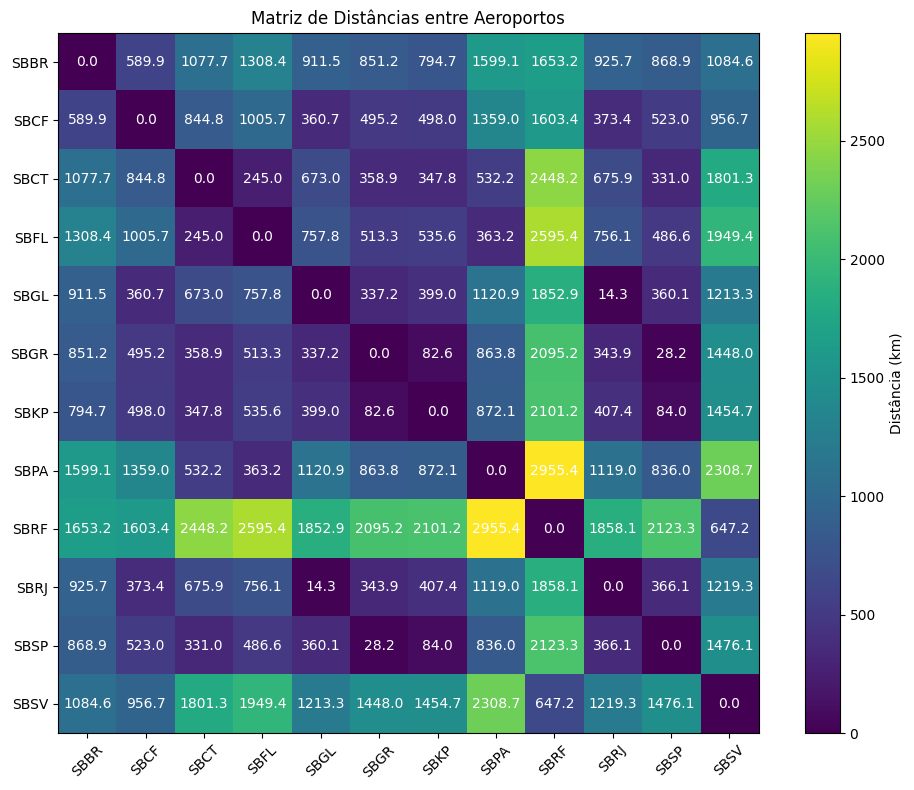

In [ ]:
import matplotlib.pyplot as plt

aeroportos = {
    'SBBR': (-15.869167, -47.920833),  # Brasília
    'SBCF': (-19.624166, -43.971943),  # Confins
    'SBCT': (-25.531944, -49.173611),  # Curitiba
    'SBFL': (-27.670556, -48.547222),  # Florianópolis
    'SBGL': (-22.810556, -43.250556),  # Galeão (Rio de Janeiro)
    'SBGR': (-23.435556, -46.473056),  # Guarulhos (São Paulo)
    'SBKP': (-23.008889, -47.134444),  # Viracopos (Campinas)
    'SBPA': (-29.993889, -51.171389),  # Porto Alegre
    'SBRF': (-8.126389, -34.924167),   # Recife
    'SBRJ': (-22.910556, -43.163056),  # Santos Dumont (Rio de Janeiro)
    'SBSP': (-23.626111, -46.656389),  # Congonhas (São Paulo)
    'SBSV': (-12.908611, -38.331944)   # Salvador
}

# Função para calcular a distância entre dois aeroportos
def calcular_distancia(aeroporto1, aeroporto2):
    coords1 = aeroportos[aeroporto1]
    coords2 = aeroportos[aeroporto2]
    return geodesic(coords1, coords2).kilometers

# Criar uma matriz de distâncias
num_aeroportos = len(aeroportos)
matriz_distancias = np.zeros((num_aeroportos, num_aeroportos))

# Preencher a matriz com as distâncias
for i, aeroporto1 in enumerate(aeroportos):
    for j, aeroporto2 in enumerate(aeroportos):
        if i != j:
            distancia = calcular_distancia(aeroporto1, aeroporto2)
            matriz_distancias[i][j] = distancia

# Plotar a matriz com os valores
plt.figure(figsize=(10, 8))
plt.imshow(matriz_distancias, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Distância (km)')
for i in range(num_aeroportos):
    for j in range(num_aeroportos):
        plt.text(j, i, f'{matriz_distancias[i, j]:.1f}', ha='center', va='center', color='white')
plt.title('Matriz de Distâncias entre Aeroportos')
plt.xticks(np.arange(num_aeroportos), aeroportos.keys(), rotation=45)
plt.yticks(np.arange(num_aeroportos), aeroportos.keys())
plt.tight_layout()
plt.show()


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302399 entries, 0 to 302398
Data columns (total 41 columns):
 #   Column                                            Non-Null Count   Dtype              
---  ------                                            --------------   -----              
 0   flightid                                          302399 non-null  object             
 1   hora_ref                                          302399 non-null  datetime64[ns, UTC]
 2   origem                                            302399 non-null  object             
 3   destino                                           302399 non-null  object             
 4   url_img_satelite                                  298666 non-null  object             
 5   metaf                                             155737 non-null  object             
 6   metar                                             300770 non-null  object             
 7   prev_troca_cabeceira                              302399

In [ ]:
dictMetafAndMetar = {}
aeroportos_unicos = np.unique(np.concatenate((data['origem'].unique(), data['destino'].unique()), axis=None))

for aeroporto in aeroportos_unicos:
    dictMetafAndMetar[aeroporto] = {}

for idx, row in data.iterrows():
    aeroporto_destino = row['destino']
    horario_ref = row['hora_ref']

    # Armazene os dicts de features (não as strings brutas)
    if not pd.isnull(row['metar']):
        if horario_ref not in dictMetafAndMetar[aeroporto_destino]:
            dictMetafAndMetar[aeroporto_destino][horario_ref] = {}
        # O dicionário de features já está em data, ex: data.loc[idx, 'metar_temperature'], etc.
        dictMetafAndMetar[aeroporto_destino][horario_ref]['metar'] = {k.replace('metar_', ''): row[k] for k in data.columns if k.startswith('metar_')}
    if not pd.isnull(row['metaf']):
        if horario_ref not in dictMetafAndMetar[aeroporto_destino]:
            dictMetafAndMetar[aeroporto_destino][horario_ref] = {}
        dictMetafAndMetar[aeroporto_destino][horario_ref]['metaf'] = {k.replace('metaf_', ''): row[k] for k in data.columns if k.startswith('metaf_')}


In [ ]:
DISTANCIA_MAXIMA = 250  # km

def calcular_aeroporto_proximos(origem, matriz_distancias):
    aeroportos_unicos = list(aeroportos.keys())
    aeroportos_proximos = []
    idx_origem = aeroportos_unicos.index(origem)
    for i, aeroporto in enumerate(aeroportos_unicos):
        if aeroporto != origem:
            distancia = matriz_distancias[idx_origem][i]
            if distancia <= DISTANCIA_MAXIMA:
                aeroportos_proximos.append((aeroporto, distancia))
    aeroportos_proximos.sort(key=lambda x: x[1])
    return aeroportos_proximos


In [ ]:

data = imputar_pareado(
    df=data,
    pareados=pareados,
    aeroportos=aeroportos,
    matriz_distancias=matriz_distancias,
    dictMetafAndMetar=dictMetafAndMetar,
    calcular_aeroporto_proximos=calcular_aeroporto_proximos
)

Imputando colunas: metar_temperature <-> metaf_temperature


TypeError: fromisoformat: argument must be str

In [ ]:
df_satelite = pd.read_parquet("/content/features_pca_95.parquet")

In [ ]:
#data.to_csv('./new_features.csv', index=False)